In [1]:
from source import source
import yfinance as yf
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,\
    mean_squared_error as mse,\
    mean_absolute_percentage_error as mape
from Backtesting.SingleTickerBacktesting import SimplePortfolioExperiment
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.samplers import TPESampler

In [1]:
import fbprophet

ModuleNotFoundError: No module named 'fbprophet'

# Gathering data

In [2]:
yndx = yf.Ticker("yndx")
model_prices = yndx.history(start="2011-05-24", end="2016-12-31", interval='1d').Close
val_prices = yndx.history(start="2016-12-31", end="2017-06-30", interval='1d').Close
test_prices = yndx.history(start="2017-06-30", end="2017-12-31", interval='1d').Close

Let us first try the most simple strategy to sell if the price is going down the next day / buy if it is going to go up.

In [3]:
class Config:
    INPUT_WINDOW_SIZE = 30
    OUTPUT_WINDOW_SIZE = 1

X_train, y_train = source.prepare_data(model_prices.values,
                           input_window_size=Config.INPUT_WINDOW_SIZE,
                           output_window_size=Config.OUTPUT_WINDOW_SIZE
                           )
y_train = y_train.ravel()
X_train.shape, y_train.shape

D:\MLDS\Year_1_project\source\source.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x)


((1381, 30), (1381,))

In [4]:
def objective(trial: optuna.Trial):

    params = {
        'alpha': trial.suggest_float('alpha', 0, 10),
        'tol': trial.suggest_float('tol', 1e-6, 1e-4)
    }

    threshold_buy = trial.suggest_float('threshold_buy', 0, 1)
    threshold_sell = trial.suggest_float('threshold_sell', 0, 1)

    model = Ridge(**params)
    model.fit(X_train, y_train)

    class Backtest(SimplePortfolioExperiment):
        def make_action(self, ind):
            #global timestamps_purchases
            #global timestamps_sellings
            prediction_data = \
                self.historical_data[ind - self.window_size + 1:ind + 1]
            transformed_data = source._transform_to_DOIU(prediction_data)
            current_price = transformed_data[-1]
            prediction = model.predict(transformed_data.reshape(1, -1))

            if current_price - prediction > threshold_buy:
                self.buy_stocks_per_money(self.free_money / 2, ind=ind, partial_operation=True)
                #timestamps_purchases.append(ind)
            elif current_price - prediction < -threshold_sell:
                self.sell_partial_papers(0.5, ind=ind, partial_operation=True)
                #timestamps_sellings.append(ind)

    experiment = Backtest(window_size=Config.INPUT_WINDOW_SIZE,
                          days_per_action=1,
                          historical_data=val_prices,
                          verbose=False)
    experiment.start_experiment()

    return sum(experiment.history_profit) / len(experiment.history_profit)

In [5]:
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)

In [6]:
study.optimize(objective, n_trials=600, show_progress_bar=True);
best = study.best_params
best, study.best_value

C:\ProgramData\Miniconda3\envs\Year_1_project\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/600 [00:00<?, ?it/s]

({'alpha': 1.936684500626929,
  'tol': 1.8768926521295897e-05,
  'threshold_buy': 0.00011329089405985203,
  'threshold_sell': 0.35599854096339895},
 1033.8717058858563)

In [7]:
model = Ridge(alpha=best['alpha'], tol=best['tol'])

In [8]:
model_prices = pd.concat((model_prices, val_prices))

In [9]:
X_train_full, y_train_full = source.prepare_data(model_prices.values,
                             input_window_size=Config.INPUT_WINDOW_SIZE,
                             output_window_size=Config.OUTPUT_WINDOW_SIZE
                             )
y_train_full = y_train_full.ravel()

D:\MLDS\Year_1_project\source\source.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x)


In [10]:
model.fit(X_train_full, y_train_full)

Ridge(alpha=1.936684500626929, tol=1.8768926521295897e-05)

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


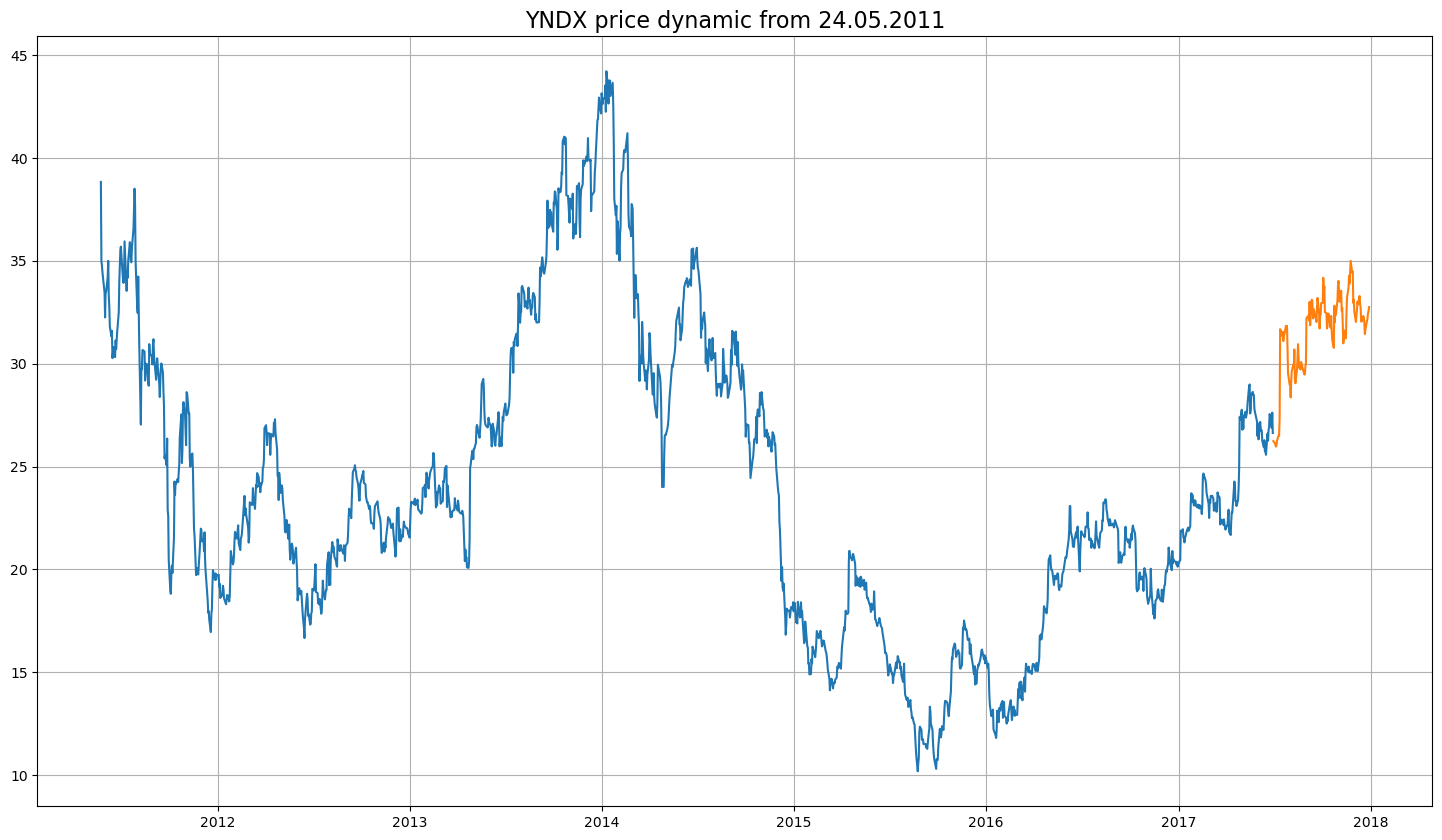

In [11]:
data = yf.Ticker('YNDX').history(period="max")
plt.figure(figsize = (18, 10))
plt.title('YNDX price dynamic from 24.05.2011', font = 'Times', fontsize = 16)
plt.grid()
plt.plot(model_prices)
plt.plot(test_prices)
plt.show()

In [40]:
class BaselineBacktest(SimplePortfolioExperiment):
    def make_action(self, ind):
        self.buy_stocks_per_money(self.free_money, ind, True)

In [41]:
baseline_experiment = BaselineBacktest(window_size=Config.INPUT_WINDOW_SIZE,
                                       days_per_action=5,
                                       historical_data=test_prices,
                                       start_capital=50000)
baseline_experiment.start_experiment()

Start portfolio experiment.


100%|██████████| 126/126 [00:00<?, ?it/s]


In [42]:
timestamps_purchases = []
timestamps_sellings = []

In [43]:
threshold_buy = best['threshold_buy']
threshold_sell = best['threshold_sell']

class Backtest(SimplePortfolioExperiment):
    def make_action(self, ind):
        global timestamps_purchases
        global timestamps_sellings
        prediction_data = \
            self.historical_data[ind - self.window_size + 1:ind + 1]
        transformed_data = source._transform_to_DOIU(prediction_data)
        current_price = transformed_data[-1]
        prediction = model.predict(transformed_data.reshape(1, -1))
        print(current_price - prediction)

        if current_price - prediction > threshold_buy:
            self.buy_stocks_per_money(self.free_money / 2, ind=ind, partial_operation=True)
            timestamps_purchases.append(ind)
        elif current_price - prediction < -threshold_sell:
            self.sell_partial_papers(0.5, ind=ind, partial_operation=True)
            timestamps_sellings.append(ind)

In [44]:
experiment = Backtest(window_size=Config.INPUT_WINDOW_SIZE,
                      days_per_action=1,
                      historical_data=test_prices,
                      verbose=False,
                      start_capital=50000)
experiment.start_experiment()

[0.00781354]
[0.01273226]
[0.01958846]
[0.00179342]
[-0.00540404]
[-0.00307626]
[0.00360013]
[-0.00239741]
[-0.00307072]
[-0.00440062]
[-0.00698284]
[-0.00438354]
[0.00185138]
[0.00247285]
[0.03258109]
[0.0168962]
[0.00473495]
[0.01588047]
[-0.01045875]
[0.01456835]
[0.00496831]
[-0.00877219]
[-0.00777292]
[0.00203335]
[-0.00502944]
[-0.00303564]
[-0.00463526]
[0.0073703]
[0.01118117]
[-0.0072982]
[-0.01563837]
[0.00195726]
[0.00077247]
[0.00914256]
[0.00485516]
[0.02155157]
[-4.15215464e-05]
[0.00667873]
[-0.01569167]
[-0.0072685]
[-0.01591158]
[-0.00659747]
[0.00365637]
[0.00254846]
[-0.00594325]
[-0.00331512]
[0.00610203]
[-0.00726175]
[-0.01032797]
[-0.01109352]
[0.02260239]
[-0.00170658]
[0.0097559]
[0.00148127]
[0.01197121]
[0.01582695]
[0.00966752]
[-0.00411868]
[-0.0079196]
[0.0029256]
[-0.01368056]
[-0.00560494]
[-0.01461518]
[-0.01973316]
[-0.00119248]
[-0.0068903]
[-0.00395083]
[0.01489688]
[0.01795484]
[0.0165902]
[0.01608757]
[0.00191163]
[0.0165324]
[-0.00109218]
[0.00028

In [45]:
timestamps_purchases, timestamps_sellings

([30,
  31,
  32,
  33,
  36,
  42,
  43,
  44,
  45,
  46,
  47,
  49,
  50,
  53,
  57,
  58,
  61,
  62,
  63,
  64,
  65,
  67,
  72,
  73,
  76,
  80,
  82,
  83,
  84,
  85,
  86,
  89,
  97,
  98,
  99,
  100,
  101,
  102,
  104,
  110,
  111,
  112,
  113,
  122,
  123,
  124,
  125,
  126],
 [])

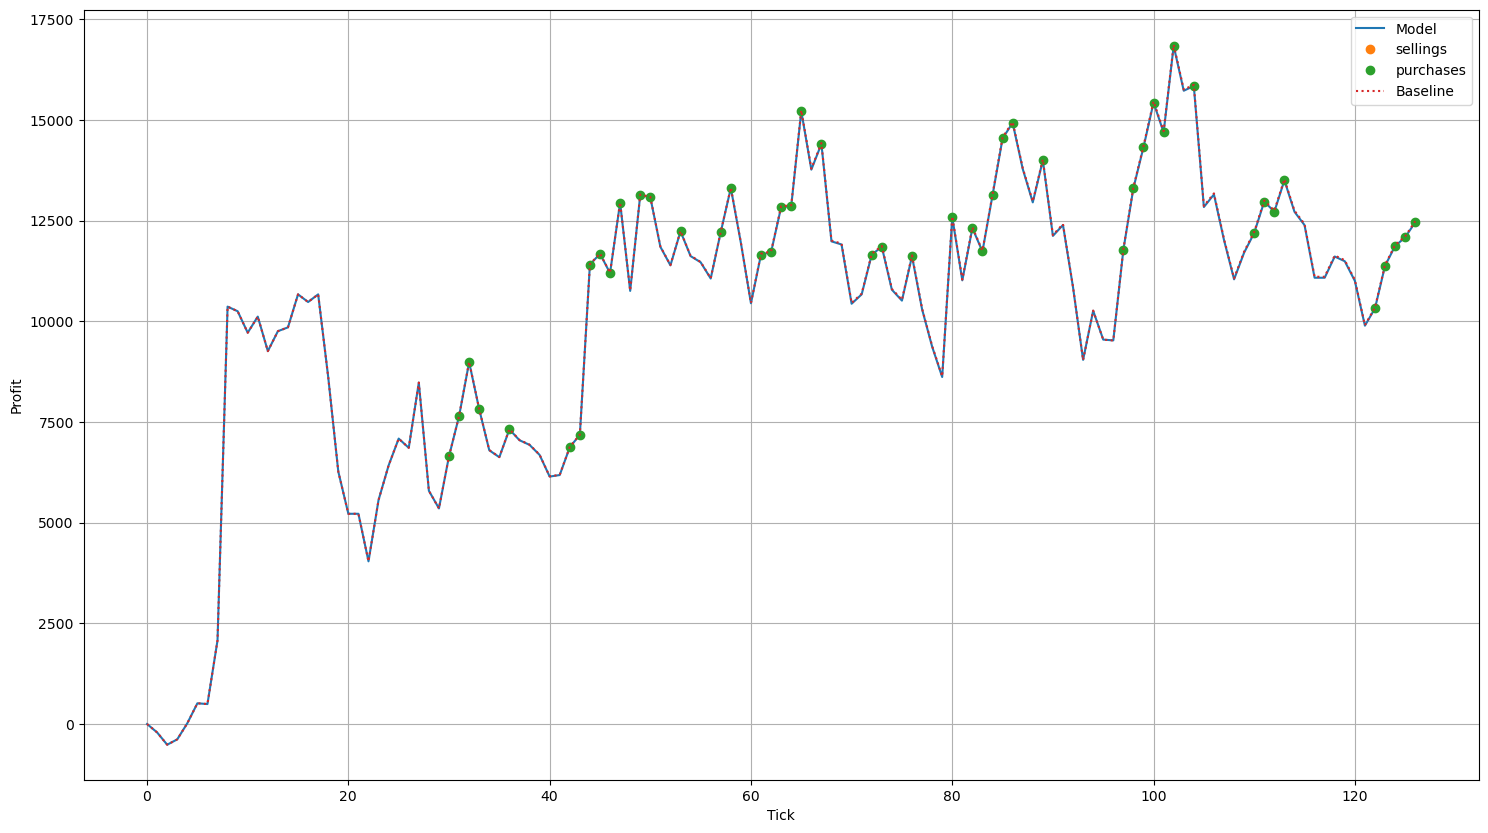

In [46]:
plt.figure(figsize = (18, 10))
plt.plot(experiment.history_profit, label='Model')
plt.plot(timestamps_sellings, [experiment.history_profit[i] for i in timestamps_sellings], 'o', label='sellings', )
plt.plot(timestamps_purchases, [experiment.history_profit[i] for i in timestamps_purchases], 'o', label='purchases')
plt.plot(baseline_experiment.history_profit, ls=':', label='Baseline')
plt.xlabel('Tick')
plt.ylabel('Profit')
plt.legend()
plt.grid()
plt.savefig('../Images/Regression vs baseline.png', bbox_inches='tight')
plt.show()